In [93]:
from pathlib import Path

import eelbrain
from matplotlib import pyplot
from matplotlib.patches import ConnectionPatch
import mne
# import plt
from matplotlib import pyplot


# Data locations
DATA_ROOT = Path("~").expanduser() / 'Data' / 'cocoha'
STIMULUS_DIR = DATA_ROOT / 'stimuli'
PREDICTOR_DIR = DATA_ROOT / 'predictors'
TRF_DIR = DATA_ROOT / 'TRFs'


# Where to save the figure
DST = DATA_ROOT / 'figures'
DST.mkdir(exist_ok=True)

# Configure the matplotlib figure style
FONT = 'Arial'
FONT_SIZE = 8
RC = {
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.transparent': True,
    # Font
    'font.family': 'sans-serif',
    'font.sans-serif': FONT,
    'font.size': FONT_SIZE,
    'figure.labelsize': FONT_SIZE,
    'figure.titlesize': FONT_SIZE,
    'axes.labelsize': FONT_SIZE,
    'axes.titlesize': FONT_SIZE,
    'xtick.labelsize': FONT_SIZE,
    'ytick.labelsize': FONT_SIZE,    
    'legend.fontsize': FONT_SIZE,
}
pyplot.rcParams.update(RC)

In [94]:
import re

# Get all subjects
SUBJECTS = [path.name for path in TRF_DIR.iterdir() if re.match(r'S\d+', path.name)]
SUBJECTS = sorted(SUBJECTS, key=lambda x: int(re.search(r'S(\d+)', x).group(1)))

print(f"Found {len(SUBJECTS)} subjects")
print(SUBJECTS)

Found 18 subjects
['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18']


In [95]:
# Load envelope TRFs for all subjects
trfs = []
r_values = []

for subject in SUBJECTS:
    attended_trf_path = TRF_DIR / subject / f'{subject}_attended_trf.pickle'
    unattended_trf_path = TRF_DIR / subject / f'{subject}_unattended_trf.pickle'

    if attended_trf_path.exists() and unattended_trf_path.exists():
        trf_attended = eelbrain.load.unpickle(attended_trf_path)
        trf_unattended = eelbrain.load.unpickle(unattended_trf_path)
        trfs.append((trf_attended, trf_unattended))
        r_values.append((trf_attended.r, trf_unattended.r))

        print(f"Loaded TRFs for {subject}")
    else:
        print(f"TRF files for {subject} not found, skipping.")
        

print(f"Loaded TRFs for {len(trfs)} subjects")

Loaded TRFs for S1
Loaded TRFs for S2
Loaded TRFs for S3
Loaded TRFs for S4
Loaded TRFs for S5
Loaded TRFs for S6
Loaded TRFs for S7
Loaded TRFs for S8
Loaded TRFs for S9
Loaded TRFs for S10
Loaded TRFs for S11
Loaded TRFs for S12
Loaded TRFs for S13
Loaded TRFs for S14
Loaded TRFs for S15
Loaded TRFs for S16
Loaded TRFs for S17
Loaded TRFs for S18
Loaded TRFs for 18 subjects


# Compare attended and unsattended TRFs

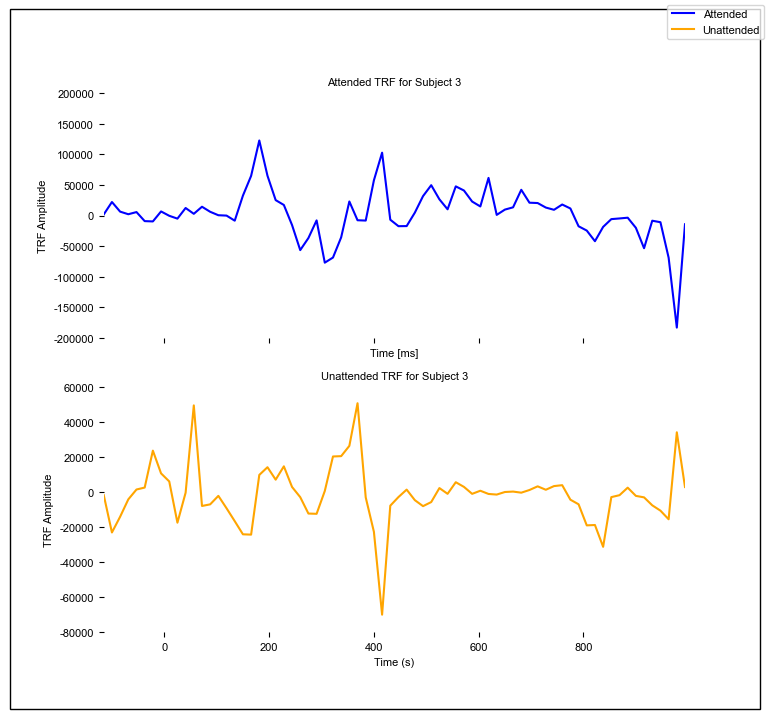

In [96]:
SUBJECT_NUMBER = 3

attended_trf_mean = trfs[SUBJECT_NUMBER -1 ][0].h_scaled.mean('sensor')
unattended_trf_mean = trfs[SUBJECT_NUMBER - 1][1].h_scaled.mean('sensor')

# plot the TRFs together in one plot for the first subject with pyplot
# Setup the figure layout
fig, axes = pyplot.subplots(2, figsize=(7.5, 7), sharex=True, subplot_kw=dict(frame_on=False))
eelbrain.plot.UTS(attended_trf_mean, axes=axes[0], color='blue')
eelbrain.plot.UTS(unattended_trf_mean, axes=axes[1], color='orange')

fig.legend(['Attended', 'Unattended'], loc='upper right')
axes[0].set_title(f'Attended TRF for Subject {SUBJECT_NUMBER}')
axes[1].set_title(f'Unattended TRF for Subject {SUBJECT_NUMBER}')
axes[0].set_ylabel('TRF Amplitude')
axes[1].set_ylabel('TRF Amplitude')
axes[1].set_xlabel('Time (s)')


eelbrain.plot.figure_outline()

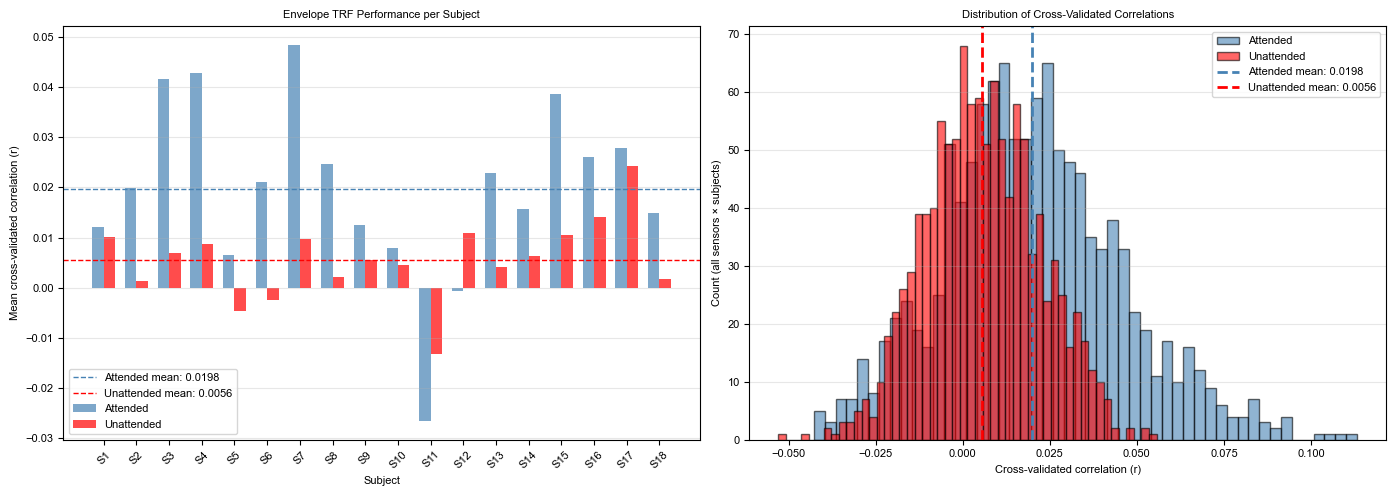

In [97]:
# Summary statistics across subjects
import numpy as np

mean_attended_r_per_subject = [r_att.mean() for (r_att, _) in r_values]
mean_unattended_r_per_subject = [r_unatt.mean() for (_, r_unatt) in r_values]


fig, (ax1, ax2) = pyplot.subplots(1, 2, figsize=(14, 5))

# Bar plot of mean correlation per subject - both attended and unattended
x = np.arange(len(mean_attended_r_per_subject))
width = 0.35  # Bar width

# Attended bars
bars1 = ax1.bar(x - width/2, mean_attended_r_per_subject, width, 
                color='steelblue', alpha=0.7, label='Attended')
# Unattended bars
bars2 = ax1.bar(x + width/2, mean_unattended_r_per_subject, width,
                color='red', alpha=0.7, label='Unattended')

# Grand means
ax1.axhline(np.mean(mean_attended_r_per_subject), color='steelblue', 
            linestyle='--', linewidth=1, 
            label=f'Attended mean: {np.mean(mean_attended_r_per_subject):.4f}')
ax1.axhline(np.mean(mean_unattended_r_per_subject), color='red', 
            linestyle='--', linewidth=1,
            label=f'Unattended mean: {np.mean(mean_unattended_r_per_subject):.4f}')

ax1.set_xlabel('Subject')
ax1.set_ylabel('Mean cross-validated correlation (r)')
ax1.set_title('Envelope TRF Performance per Subject')
ax1.set_xticks(x)
ax1.set_xticklabels([f'S{i+1}' for i in range(len(mean_attended_r_per_subject))], rotation=45)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Histogram of correlation values - both attended and unattended
all_r_attended = np.concatenate([r.x.flatten() for (r, _) in r_values])
all_r_unattended = np.concatenate([r.x.flatten() for (_, r) in r_values])

ax2.hist(all_r_attended, bins=50, color='steelblue', alpha=0.6, 
         edgecolor='black', label='Attended')
ax2.hist(all_r_unattended, bins=50, color='red', alpha=0.6, 
         edgecolor='black', label='Unattended')

ax2.axvline(all_r_attended.mean(), color='steelblue', linestyle='--', linewidth=2,
            label=f'Attended mean: {all_r_attended.mean():.4f}')
ax2.axvline(all_r_unattended.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Unattended mean: {all_r_unattended.mean():.4f}')

ax2.set_xlabel('Cross-validated correlation (r)')
ax2.set_ylabel('Count (all sensors × subjects)')
ax2.set_title('Distribution of Cross-Validated Correlations')
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

pyplot.tight_layout()
pyplot.show()